In [1]:
import openpyxl
print("openpyxl installed successfully!")


openpyxl installed successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import shap  # for feature importance analysis
import warnings
warnings.filterwarnings("ignore")

In [27]:
data = pd.read_csv(r"C:\Project\livertransplant\datasets\cleaned_data.csv")

In [28]:
# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (125, 27)
   AGE GENDER  MELD at Surgery  End Portal Pressure  \
0   62      M             25.0                 11.0   
1   41      M             19.0                 12.0   
2   39      M             32.0                 11.0   
3   67      M              9.0                 10.0   
4   60      M             11.0                 10.0   

                                      RECONSTRUCTION      HEIGHT  WEIGHT  \
0                                IRHV reconstruction  163.000000    71.0   
1               SRHV+RHV - Quilt & Fence Patch, IRHV  168.833628    72.9   
2  V8  on cadaveric iliac vein, 2 IRHV on fence g...  168.000000    69.0   
3                      V5 + V8 + IRHV reconstruction  178.000000    81.0   
4                         V8 on cadaveric iliac vein  165.000000    71.0   

   GRAFT WEIGHT  CIT  SECONDARY WARM ISCHAEMIC TIME  ...  PLATELET COUNT  \
0         439.0   64                             32  ...    98466.902957   
1         557.0   77               

In [29]:
# %% [markdown]
# ## 3. Data Preprocessing & Exploratory Data Analysis (EDA)
# 
# In this section, we:
# - Check for missing values and handle them.
# - Encode categorical variables.
# - Scale numerical features.
# - Optionally, remove outliers.
# - Perform basic exploratory data analysis (EDA).

# %% [code]
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
AGE                               0
GENDER                            0
MELD at Surgery                   0
End Portal Pressure               0
RECONSTRUCTION                    0
HEIGHT                            0
WEIGHT                            0
GRAFT WEIGHT                      0
CIT                               0
SECONDARY WARM ISCHAEMIC TIME     0
END LACTATE                      23
Blood loss                        3
DM                                0
ENCEPHALOPATHY                    0
ASCITES                           0
CHILD PUGH SCORE                 68
HB                               11
PLATELET COUNT                    0
INR                               0
S.FIBRINOGEN                     19
TOTAL BILLIRUBIN                 10
CREATININE                        0
ALBUMIN                           0
Porto-caval shunt                 0
Intraop peak lactate              5
Intraop End lactate               6
SFSS                              0
d

In [30]:
# Handling missing values: For simplicity, impute numerical features with the median.
for col in data.select_dtypes(include=[np.number]).columns:
    data[col].fillna(data[col].median(), inplace=True)

# If there are categorical columns, perform label encoding (or One-Hot Encoding as needed)
categorical_cols = data.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

# Scale the numerical features using StandardScaler or MinMaxScaler.
scaler = StandardScaler()
num_cols = data.select_dtypes(include=[np.number]).columns.drop('SFSS')  # assuming 'SFSS' is our target
data[num_cols] = scaler.fit_transform(data[num_cols])

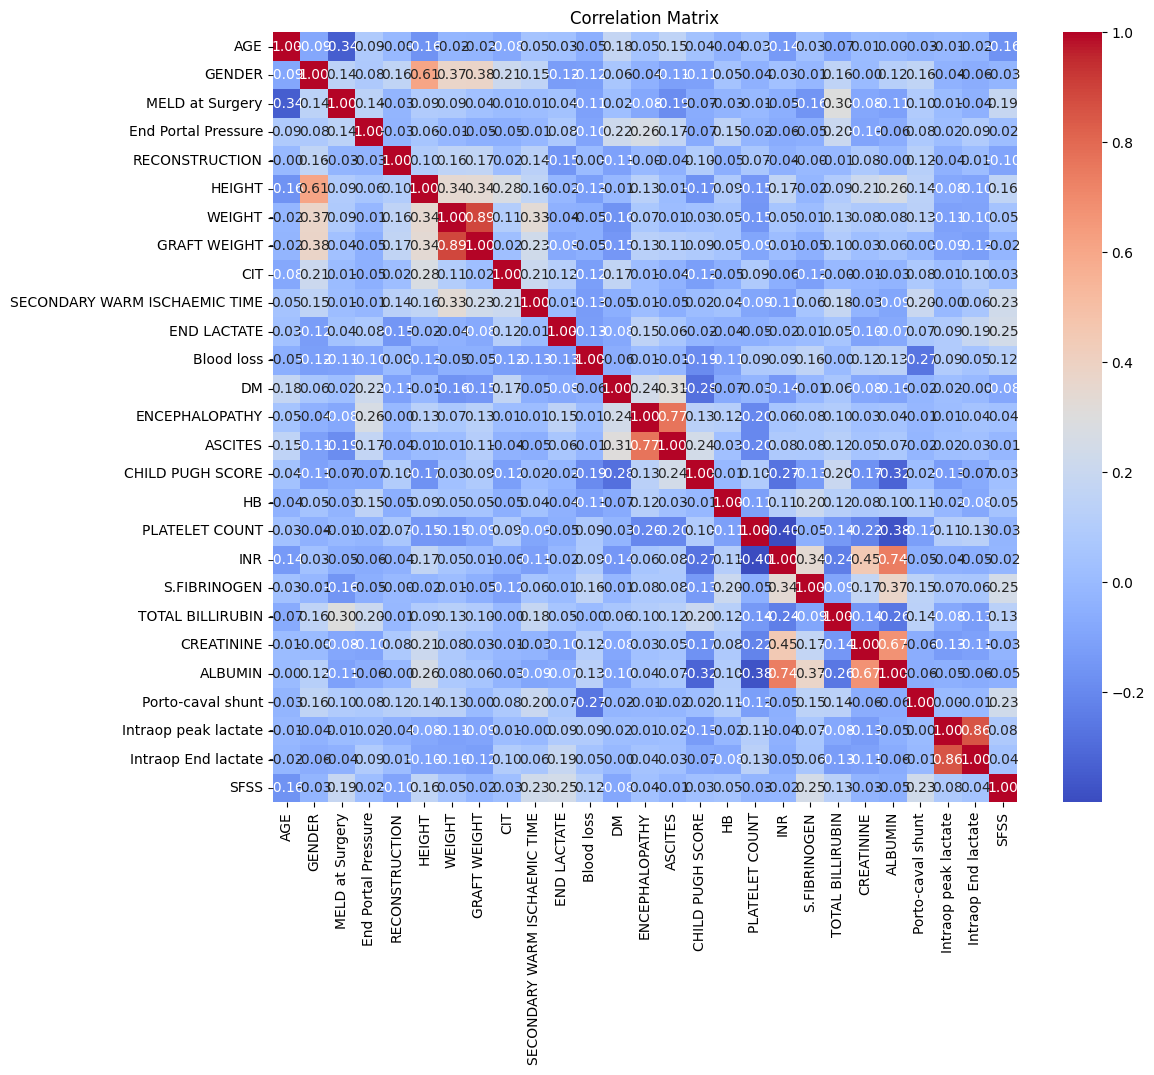

In [31]:
# EDA: Visualize correlation matrix to see relationships
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [34]:
# %% [markdown]
# ## 4. Baseline Model Training
# 
# We now split the data into training and testing sets and train multiple baseline models:
# Logistic Regression, Random Forest, and XGBoost.

# %% [code]
# Separate features and target variable
# Example: converting continuous SFSS to binary (0, 1) using a threshold of 0.5
data['SFSS'] = (data['SFSS'] > 0.5).astype(int)
X = data.drop("SFSS", axis=1)  # all features
y = data["SFSS"]               # target variable

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Train Logistic Regression as baseline
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))


Logistic Regression Accuracy: 0.88


In [36]:
# Train Random Forest Classifier as baseline
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.88


In [37]:
# Train XGBoost Classifier as baseline
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

XGBoost Accuracy: 0.88


In [38]:
# %% [markdown]
# ## 5. Forward Feature Selection (Iterative Process)
# 
# In this section, we start with an empty feature set and add features one by one. After each addition, we evaluate 
# the model using cross-validation on the training set. The process stops when adding a new feature does not improve accuracy.

# %% [code]
selected_features = []
remaining_features = list(X.columns)
best_score = 0
best_features = []


In [39]:
# Iteratively add features
for i in range(len(remaining_features)):
    scores = []
    for feature in remaining_features:
        temp_features = selected_features + [feature]
        model = LogisticRegression(random_state=42)
        cv_score = np.mean(cross_val_score(model, X_train[temp_features], y_train, cv=5))
        scores.append((feature, cv_score))
    
    # Sort scores by best accuracy
    scores.sort(key=lambda x: x[1], reverse=True)
    best_feature, best_feature_score = scores[0]
    
    if best_feature_score > best_score:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_feature_score
        best_features = selected_features.copy()
        print(f"Iteration {i+1}: Added {best_feature}, CV Accuracy: {best_feature_score:.4f}, Features: {selected_features}")
    else:
        print("No improvement after adding features. Stopping selection.")
        break

print("\nOptimal Feature Set:", best_features)
print("Best Cross-Validation Accuracy:", best_score)


Iteration 1: Added AGE, CV Accuracy: 0.9800, Features: ['AGE']
No improvement after adding features. Stopping selection.

Optimal Feature Set: ['AGE']
Best Cross-Validation Accuracy: 0.9800000000000001


In [40]:
# %% [markdown]
# ## 6. Model Optimization & Hyperparameter Tuning
# 
# Using the optimal feature set from forward selection, we tune hyperparameters using GridSearchCV for the chosen model.
# Here we demonstrate tuning for Logistic Regression.

# %% [code]
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # l1 penalty requires solver='liblinear' but we'll keep it simple
    'solver': ['lbfgs']
}


In [41]:
# Setup GridSearchCV
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train[best_features], y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Train the final model using the best parameters
final_model = grid.best_estimator_
final_model.fit(X_train[best_features], y_train)
final_preds = final_model.predict(X_test[best_features])
print("Final Test Accuracy:", accuracy_score(y_test, final_preds))

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.9800000000000001
Final Test Accuracy: 0.88


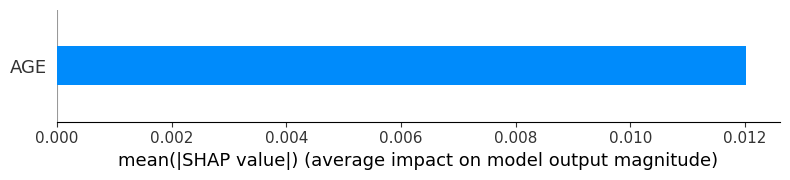

In [42]:
# %% [markdown]
# ## 7. Feature Importance Analysis
# 
# We use SHAP values to understand feature contributions in our final model. SHAP explains model predictions by 
# measuring each feature's contribution.

# %% [code]
# Use SHAP to explain model predictions
# (Note: SHAP can be computationally expensive on large datasets)
explainer = shap.LinearExplainer(final_model, X_train[best_features], feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train[best_features])

# Plot SHAP summary
shap.summary_plot(shap_values, X_train[best_features], plot_type="bar")


In [43]:
import os
import joblib

# Create the models folder if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")

# Save the final model to the models folder
joblib.dump(final_model, "models/sfss_prediction_model.pkl")
print("Model saved successfully in the 'models' folder as sfss_prediction_model.pkl")


Model saved successfully in the 'models' folder as sfss_prediction_model.pkl
